In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma
np.set_printoptions(threshold=np.inf)

Suppose we have some raw data for which we model using:
$$ Y_1, ..., Y_n\mid\mu, \sigma^2  \sim \text{Normal}(\mu, \sigma^2) $$

Where we have our parameters distributed by some distributions below:

$$ \mu\sim \text{Normal}(v, \phi_0^2) \quad \sigma^2 \sim \text{InvGa}(a, b) $$

Where $\mu_0$, $a$, $b$, $\sigma_0^2$ are fixed constants

# Priors

In [2]:
a, b = 3, 0
v, phi = 0, 2

In [3]:
u = norm.rvs(v, phi)
s = invgamma.rvs(a, b)

In [4]:
y = norm.rvs(u, pow(s, 0.5), 50)

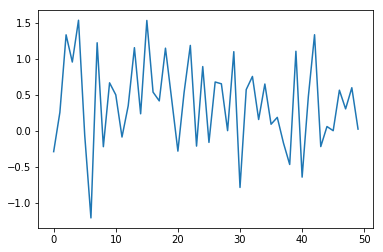

In [5]:
plt.plot(y)
plt.show()

In [6]:
u_grid = np.linspace(-5,5, 21)
s_grid = np.linspace(0,1.5,21)

prior_u = np.array([norm.pdf(u_grid,v, phi)])
prior_s = np.array([invgamma.pdf(s_grid, a, b)])

prior = np.outer(prior_u, prior_s)

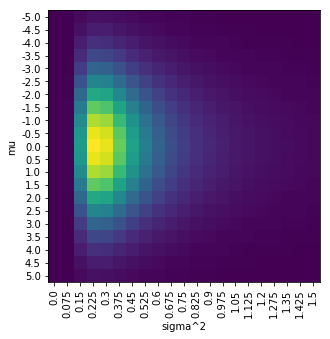

In [7]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_xticklabels(s_grid)
plt.xticks(range(len(s_grid)), rotation = 90)
ax.set_yticklabels(u_grid)
plt.yticks(range(len(u_grid)))
plt.xlabel("sigma^2")
plt.ylabel("mu")
plt.imshow(prior)
plt.show()

In [8]:
np.shape(prior)

(21, 21)

# Likelihood

Now we have a matrix showing us the prior probability of that combination of $\mu$ and $\sigma^2$, we create  a likelihood function which computed the probability that our data was drawn from a Normal distribution with the specified parameters.

$$ \text{P}(Y_i = y_i \mid \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left\{-\frac{(y_i - \mu)^2}{2 \sigma^2}\right\} $$ 

In [9]:
def likelihood(y_val, u_val, s_val):
    return norm.pdf(y_val, u_val, s_val)

# Everything above this is setup, the answer to your question lies here:
lik_fn = np.vectorize(likelihood)

# Posterior

In [12]:
for y_val in y:
    lik_mat = np.zeros((len(u_grid),len(s_grid)))
    for i in range(len(u_grid)):
        for j in  range(len(s_grid)):
            lik_mat[i,j] = likelihood(y_val, u_grid[i], pow(s_grid[j], 0.5))
            lik_mat = np.nan_to_num(lik_mat)
    post_mat = (lik_mat * prior) / np.nan_to_num((lik_mat * prior).sum())
    post_mat = np.nan_to_num(post_mat)
    prior = post_mat

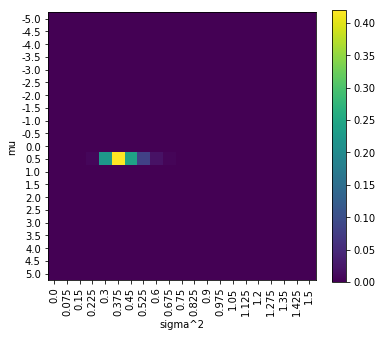

In [13]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
plt.imshow(post_mat)
plt.colorbar(orientation='vertical')
ax.set_xticklabels(s_grid)
plt.xticks(range(len(s_grid)), rotation = 90)
ax.set_yticklabels(u_grid)
plt.yticks(range(len(u_grid)))
plt.xlabel("sigma^2")
plt.ylabel("mu")
plt.show()

In [16]:
u

0.36515569213417043

In [15]:
s

0.4792482685602622